#**Drunk Face Classification**

Nico and I were joking in Berlin about how it might be cool to create an AI that can measure so-called highness and send each other results for fun. The idea turned out to be a project in AI Lab. In AI Lab, we have been working on constructing machine learning model mainly CNN model for estimating ones' sobriety level. I thought this assignment can be a perfect opportunity for me to further explore on what other apperoach can be used to predict one's sobriety. 

***this file is designed to be run on Google Colaboratory. Run cells one by one and read the instruction before running**

###**1. Importing libraries and data**

**Importing libraries**

When it is the first time running, the error will pop up saying restart the runtime. Restart the runtime and rerun the code cell below to make it properly work. 

In [ ]:
! pip install opencv-contrib-python-headless
! pip install imgaug
! pip install pillow-heif

import cv2
import pandas as pd
import os
from matplotlib import pyplot
from math import sqrt 
import numpy as np 
import scipy.misc 
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform
from matplotlib.pylab import rcParams
from PIL import Image
import imgaug as ia
from imgaug import augmenters as iaa
import itertools
import glob
import random
from pillow_heif import register_heif_opener
from skimage import io
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importing data**

**Sobr**

As an external dataset is obtained from Sobr (https://github.com/hoke-t/Sobr) by Chang, J., Hoke, T., Dastjerdi, P. & Kumar, H (2019). The dataset consist of 728x728 pixel RGB images of 53 people with differing level of sobriety. The left most face is for completely sober state, which is important to acknowledge for the data preprocessing.  

Although there is no mentioning of where and how this data is collected, it is speculated that the data is collected from volunteers. It poses significant ethical considerations that need to be made before using the data. Firstly, there is a lack of formal consent from people whose faces are included in the dataset to be used in this project.

Secondly, there could be a demographical bias. For example, there is no Asian present in the dataset. The bias can make machine learning model perform poorly on certain demographics of people, which can cause ethical consequences depending on the use cases. This point will be discussed further. Finally, sobriety can be though of sensitive and private information. The act of classifying and revealing one's sobriety openly can be considered as an invasion of privacy. 

 It is crucial to acknowledge those ethical consequences and use these data and machine learning model carefully to avoid any of those consequence. 

Before running the below cells, upload secondary files submitted. (drunkIMagesWebp.zip, personal.zip, haarcascade_frontalface_alt.xml)

In [ ]:
!unzip drunkImagesWebp

Archive:  drunkImagesWebp.zip
   creating: drunkImages/
  inflating: drunkImages/d4a7a2_489a118eae5c42d0a925a538fd12b87f.webp  
  inflating: drunkImages/d4a7a2_1058015d1eaa4d37a57c0d6248601a76.webp  
  inflating: drunkImages/d4a7a2_19b84434c387464fbce5fc15f8edd49c.webp  
  inflating: drunkImages/d4a7a2_3acbd218dcb44816946c0e56027aaa6b.webp  
  inflating: drunkImages/d4a7a2_78e6afe2d8c947c99c92e6919e04ce67.webp  
  inflating: drunkImages/d4a7a2_de23266b935d4b7a8777c08fab1ec4a8.webp  
  inflating: drunkImages/d4a7a2_a6b5a4970d614c03a58e940f0d7de7f3.webp  
  inflating: drunkImages/d4a7a2_910e754e7ac44de498faf5056b4f9d14.webp  
  inflating: drunkImages/d4a7a2_b6616f6ce6e948cc99647b297d1aeb49.webp  
  inflating: drunkImages/d4a7a2_7689c31a6f7947738c12d397d69d9119.webp  
  inflating: drunkImages/d4a7a2_efb25ba84f1e4274a8a17ee481cfa050.webp  
  inflating: drunkImages/d4a7a2_209ddf0fcd4d4f9a88cdadf48bb8d534.webp  
  inflating: drunkImages/d4a7a2_951e0382ca1a44aeafe8a0219e02dc42.webp  
  inflat

**my data**

Aside from external data, I will use my personal data from my phone to compare the models' results. As my data is from my phone, I need to use different packages to import and preprocess data. I took permission from everyone who appear in the data to make sure that the ethical consequences can be minimised. The dataset only contain 12 faces and mostly come from Asian people, which is expected to cause significant demographical bias in classifer. 

In [ ]:
!unzip personal

Archive:  personal.zip
   creating: personal/
  inflating: personal/0_IMG_4002.HEIC  
  inflating: __MACOSX/personal/._0_IMG_4002.HEIC  
  inflating: personal/1_IMG_0779.JPG  
  inflating: __MACOSX/personal/._1_IMG_0779.JPG  
  inflating: personal/1_IMG_0698 copy.HEIC  
  inflating: __MACOSX/personal/._1_IMG_0698 copy.HEIC  
  inflating: personal/1_IMG_0596.JPG  
  inflating: __MACOSX/personal/._1_IMG_0596.JPG  
  inflating: personal/1_IMG_0609.JPG  
  inflating: __MACOSX/personal/._1_IMG_0609.JPG  
  inflating: personal/0_IMG_0698.HEIC  
  inflating: __MACOSX/personal/._0_IMG_0698.HEIC  
  inflating: personal/0_IMG_9733.HEIC  
  inflating: __MACOSX/personal/._0_IMG_9733.HEIC  
  inflating: personal/0_IMG_973.HEIC  
  inflating: __MACOSX/personal/._0_IMG_973.HEIC  
  inflating: personal/1_IMG_0609 copy.JPG  
  inflating: __MACOSX/personal/._1_IMG_0609 copy.JPG  
  inflating: personal/1_IMG_9781.HEIC  
  inflating: __MACOSX/personal/._1_IMG_9781.HEIC  
  inflating: personal/0_IMG_2009.H

###**2. Loading data and data preprocessing**

First function coverts all the images in a file to jpg so that it is easier to handle. 

In [ ]:
def convert_file_to_jpg(filepath, newfilename):
  """
  Convert all the images in a file to jpg and store them in new file

  Parameters
  -----------------
  filepath (str): The path of a file containing images
  newfilename (str): New path of a file that jpgs will be stored

  Returns
  -----------------
  None
  """
  register_heif_opener()
  
  # create file if it doesn't exist
  if not os.path.exists(newfilename):
      os.makedirs(newfilename)

  # saving images in a new file in jpg
  for file in os.listdir(filepath):
    filename = os.fsdecode(file)
    filenumber = os.path.splitext(filename)[0]
    if filename == '.DS_Store':
      continue
    im = Image.open(filepath+'/'+filename).convert("RGB")
    im.save(newfilename + f"/{filenumber}.jpg","jpeg")

  return None

In [ ]:
convert_file_to_jpg('drunkImages', 'external')
convert_file_to_jpg('personal', 'internal')

Secondly, all of the images are scanned by the Haarcascade pretrained facial recognition model by OpenCV (https://github.com/kipr/opencv/tree/master/data/haarcascades) to detect and crop faces from the images. The images can be resized designated image size. The resizing can avoid using too much memory when fitting the model on the data. When external dataset (Sobr dataset) is passed, the labels are returned. The upper left corner of the original image is the sober picture, and the rest of three are drunk picture taken at different time. The below function makes use of that to get appropriate labels. 

In [ ]:
def convert_jpg_to_face(filepath, newfilename, img_size, external=True):
  """
  Detect and crop faces in images in a file and store them in new file

  Parameters
  -----------------
  filepath (str): The path of a file containing images
  newfilename (str): New path of a file that faces will be stored
  img_size (tuple): The size of cropped face image
  external (bool, default=True): If the dataset is from Sobr or not

  Returns
  -----------------
  labels (np array): if data is Sobr, labels are stored here. Else, it is empty
  """
  labels = []

  # create file if it doesn't exist
  if not os.path.exists(newfilename):
      os.makedirs(newfilename)

  # face detection using OpenCV
  j = 0
  for file in os.listdir(filepath):
      # reading an image
      filename = os.fsdecode(file)
      img = cv2.imread(filepath+'/'+filename)

      # converting the image into grayscale and classifying faces
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
      faces = face_cascade.detectMultiScale(gray, 1.3, 4)

      # saving every faces as a new image in a new file
      if len(faces) != 0:
        for i, (x,y,w,h) in enumerate(faces):

            # if the data is external, it handles labels automatically
            if external:
              if (x < 364) and (y < 364):
                labels.append(0)
              else:
                labels.append(1)

            # if the data is personal, it gets label from the title
            else:
              label = int(os.path.splitext(filename)[0][0])
              labels.append(label)

            # resizing facial images and saving it in the new file
            face = img[y:y+h, x:x+w]
            face = cv2.resize(face, (img_size[0],img_size[1]))
            cv2.imwrite(newfilename + f"/{j}.jpg", face)
            j += 1

  return np.asarray(labels)

In [ ]:
img_size = (32,32,3)
y_external = convert_jpg_to_face('external', 'faces_ex', img_size)
y_internal = convert_jpg_to_face('internal', 'faces_in', img_size, external=False)

As the data contains small number of pictures, it performs data augumentations: adding noises, bluring, changing contrast, flipping, and warping the facial images. The below function can create any number of augmented images from the original data.  The function is inspired by Chang, J., Hoke, T., Dastjerdi, P. & Kumar, H (2019). 

In [ ]:
def aug_data(filepath, newfilename, y, n_data=5000):
  """
  augument images in a file and store the data to a new file

  Parameters
  -----------------
  filepath (str): The path of a file containing images
  newfilename (str): New path of a file that augumented data will be stored
  y (np array): labels assiciated with original image.
  n_data (int, default-10000): Number of augumented data generated

  Returns
  -----------------
  labels (np array): labels for all augumented data
  """
  labels = []

  # create file if it doesn't exist
  if not os.path.exists(newfilename):
      os.makedirs(newfilename)
  
  # data augumentations performed
  meta = {'noop': iaa.Noop(), 'shuffle': iaa.ChannelShuffle(p=1.0)}

  arithmetic = {'add-45': iaa.Add(value=-45),
                'add-25': iaa.Add(value=-25), 'add+25': iaa.Add(value=25), 'add+45': iaa.Add(value=45),
                'addp-': iaa.Add(value=(-35, -15), per_channel=True), 'addp+': iaa.Add(value=(15, 35), per_channel=True),
                'addGN': iaa.AdditiveGaussianNoise(scale=0.10 * 255),
                'addGNp': iaa.AdditiveGaussianNoise(scale=0.10 * 255, per_channel=True),
                'addLN': iaa.AdditiveLaplaceNoise(scale=0.10 * 255),
                'addLNp': iaa.AdditiveLaplaceNoise(scale=0.10 * 255, per_channel=True),
                'addPN': iaa.AdditivePoissonNoise(lam=16.00),
                'addPNp': iaa.AdditivePoissonNoise(lam=16.00, per_channel=True),
                'mul-': iaa.Multiply(mul=0.50), 'mul+': iaa.Multiply(mul=1.50),
                'mulp-': iaa.Multiply(mul=0.8, per_channel=True), 'mulp+': iaa.Multiply(mul=1.2, per_channel=True),
                'jpeg': iaa.JpegCompression(compression=12), 'jpeg+': iaa.JpegCompression(compression=15),
                'jpeg++': iaa.JpegCompression(compression=17)}

  blur = {'GBlur': iaa.GaussianBlur(sigma=1.00),
          'ABlur': iaa.AverageBlur(k=3), 'MBlur': iaa.MedianBlur(k=3),
          'BBlur': iaa.BilateralBlur(sigma_color=250, sigma_space=250, d=5),
          'MoBlur': iaa.MotionBlur(angle=0, k=7), 'MoBlurAng': iaa.MotionBlur(angle=144, k=5)}

  contrast = {'GContrast-': iaa.GammaContrast(gamma=0.81),
              'GContrast+': iaa.GammaContrast(gamma=1.44), 'SContrast': iaa.SigmoidContrast(cutoff=0.5, gain=10),
              'LContrast': iaa.LogContrast(gain=0.88), 'LiContrast': iaa.LinearContrast(alpha=1.38)}

  flip = {'flipLR': iaa.Fliplr(p=1.0)}

  geometric = {'PAffine': iaa.PiecewiseAffine(scale=0.030), 'PTrans-': iaa.PerspectiveTransform(scale=0.05),
              'PTrans': iaa.PerspectiveTransform(scale=0.15), 'PTrans+': iaa.PerspectiveTransform(scale=0.2),
              'ETrans': iaa.ElasticTransformation(sigma=1.0, alpha=2.1)}

  effects = {**meta, **arithmetic, **blur, **contrast, **flip, **geometric}

  count = 0

  for i in range(2):
      # combinations of all the effects
      combs = list(itertools.combinations(effects.keys(), i + 1))

      # Shuffles the array in-place
      combs = random.sample(combs, len(combs))

      # perform augumentation using iaa
      for aug in combs:

          if count > n_data:
              break

          aug_effects = list(map(lambda x: effects[x], aug))

          if not len(aug_effects) - 1:
              seq = aug_effects[0].to_deterministic()

          else:
              seq = iaa.Sequential(aug_effects).to_deterministic()

          # performing each effect on all the images in a file
          for file in os.listdir(filepath):
              filename = os.fsdecode(file)
              filenumber = int(os.path.splitext(filename)[0])
              labels.append(y[filenumber])
              img = cv2.imread(filepath+'/'+filename, cv2.IMREAD_COLOR)
              aug_img = seq.augment_image(img)

              cv2.imwrite(newfilename + f"/{count}.jpg", aug_img)

              count += 1

  return np.asarray(labels)

In [ ]:
y_ext = aug_data('faces_ex', 'aug_faces_ex', y_external)
y_int = aug_data('faces_in', 'aug_faces_in', y_internal)

The below function performs the conversion from jpg in a directory to numpy array.

In [ ]:
def convert_jpg_to_array(filepath, labels, img_size):
  """
  convert jpg to numpy array

  Parameters
  -----------------
  filepath (str): The path of a file containing images
  img_size (tuple): image size of images

  Returns
  -----------------
  X (np array): images in numpy array
  """
  X = []
  y = []

  # converting images into numpy array with sepcified dimensions
  for file in os.listdir(filepath):
      filename = os.fsdecode(file)
      filenumber = int(os.path.splitext(filename)[0])
      y.append(labels[filenumber])
      img = cv2.imread(filepath+'/'+filename)
      img = img.reshape(img_size[0]*img_size[1]*img_size[2])
      X.append(img)

  return np.asarray(X), np.asarray(y)

In [ ]:
X_ex, y_ex = convert_jpg_to_array('aug_faces_ex', y_ext, img_size)
X_in, y_in = convert_jpg_to_array('aug_faces_in', y_int, img_size)

###**3. Exploratory data analysis**

Then, the function below can plot 9 randomely selected images in np.array. The data can deal with plotting any dimenstion and color map. 

In [ ]:
def plot_rand_imgs(data, img_size, pred='nan', actual='nan'):
  """
  choose 9 random images stored in numpy array and plot them 

  Parameters
  -----------------
  data (numpy array): numpy array containing images
  img_size (tuple): image size of images

  Returns
  -----------------
  None (show plot)
  """
  # images selected
  random_ids = np.random.choice(data.shape[0], 9)

  # for every image, plot it as a subplot
  j = 0
  fig = plt.figure()
  for i in random_ids: 
    ax = plt.subplot(330 + 1 + j)
    ax.axis('off') 
    # if there is a list of predictions, display it as title
    if type(actual) != str:
      title = f'actual: {actual[i]}'
      if type(pred) != str:
        title += f', pred: {pred[i]}'
      ax.title.set_text(title)
    # if RGB is stored, convert it to RGB
    if img_size[2]==3:
      ax.imshow(cv2.cvtColor(data[i].reshape(img_size[0], img_size[1], img_size[2]), cv2.COLOR_BGR2RGB))
    # if grayscale is stored, plot it with gray color map
    elif img_size[2]==1:
      ax.imshow(data[i].reshape(img_size[0], img_size[1], img_size[2]), plt.get_cmap('gray'))

    j += 1

  plt.axis('off')
  plt.show()

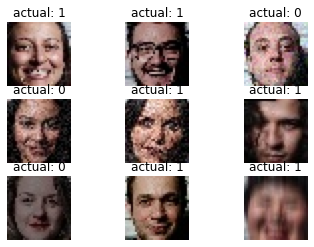

In [ ]:
plot_rand_imgs(X_ex, img_size, actual=y_ex)

In [ ]:
plot_rand_imgs(X_in, img_size, actual=y_in)

From the plots above, it can be confirmed that the data augumentations are performed correctly and the labels are correctly assigned. the function below generates dataframe of unique values and their frequency in a numpy array. It is used to see the frequency of drunk and sober face in both datasets. 

In [ ]:
def unique_frequency(y):
  """
  return dataframe of unique values and their counts in numpy array 

  Parameters
  -----------------
  y (numpy array): any numpy array (1D)

  Returns
  -----------------
  df (panda dataframe): unique values and their frequency
  """
  unique, counts = np.unique(y, return_counts=True)
  data = {'category':unique, 'counts':counts}
  df = pd.DataFrame(data)

  return df

In [ ]:
unique_frequency(y_ex)

,category,counts
0,0,1450
1,1,3596


The above shows the frequency of sober and drunk faces in the external dataset. It reveals that the external dataset coutain roughly 2.5 times drunk faces than sober faces. It is because the original images all contain 1 sober face and 3 drunk faces taken in different time. The skewed distribution of categories can impact the result of the training. 

In [ ]:
unique_frequency(y_in)

,category,counts
0,0,2004
1,1,3006


The above shows the frequency of sober and drunk faces in the personal dataset. The number of drunk faces is 1.5 times larger than that of sober faces. This could also impact the result. 

###**4. Overall pipeline**

**Task performed**

As mentioned, a machine learning model will be trained to classify sober and drunk face. There will be three datasets to used for model training: external dataset, personal dataset, and mixed dataset. Firstly, the external dataset and personal dataset are both splitted into training and test data. The test data is set to 10% for each, which can be combined to get 20% of all the data. The training data for mixed data is obtained by combining both external and personal training data and discarding half of it. The data is reduced to make the size of training data approximately the same across all the datasets.

Before the model is trained, PCA is performed as dimentionality reduction technique. The motivation is oulined below where PCA is explained in detail. Then, random search cross validation is performed to find the set of parameters that lead to the best cross validation score. This will also be discussed further below. Then, The model will be trained and performances are measured and compared.

In [ ]:
# splitting both external and personal datasets to training and testing (testing 10%)
X_ex_train, X_ex_test, y_ex_train, y_ex_test = train_test_split(X_ex, y_ex, test_size=0.1)
X_in_train, X_in_test, y_in_train, y_in_test = train_test_split(X_in, y_in, test_size=0.1)

# combining test data from both to make test data with the size 20% of all the data
X_test = np.vstack((X_ex_test, X_in_test))
y_test = np.append(y_ex_test, y_in_test)

# mix the training data from both external and personal data
X_mix = np.vstack((X_ex_train, X_in_train))
y_mix = np.append(y_ex_train, y_in_train)

# discard half of the data to make the size of all the datasets approximately the same
X_mix_train, _, y_mix_train, _ = train_test_split(X_mix, y_mix, train_size=0.5)

In [ ]:
print("dimensions of data used for training and testing")
print("training dataset for case 1: ", X_ex_train.shape, y_ex_train.shape)
print("training dataset for case 2: ", X_in_train.shape, y_in_train.shape)
print("training dataset for case 3: ", X_mix_train.shape, y_mix_train.shape)

print("test dataset: ", X_test.shape, y_test.shape)

dimensions of data used for training and testing
training dataset for case 1:  (4541, 3072) (4541,)
training dataset for case 2:  (4509, 3072) (4509,)
training dataset for case 3:  (4525, 3072) (4525,)
test dataset:  (1006, 3072) (1006,)


####**-PCA**

**Why do PCA?**

Although XGBoost algorithm is constructed to improve runtime by reducing number of computation as much as possible like illustrated below and by making use of parallel learning and memory allocation technique, it still struggles with huge dimension of data like an image as image has too many dimensions to find the best similarity score from. It motivates the use of dimensionality reduction which can be done by multiple techniques such as PCA and pretrained autoencoders. 

**How does PCA work?** (explanation is inspired by Jaadi, Z (2022))

The PCA tries to find the set of axis or eigenvectors that can express the data's variation the most so that the most variation can be captured with lower dimensions. This can be done by finding a line with minimum residuals to the data. By looking at Pythagorean theorem, it can be observed that minimising residuals is equivalent of finding a line maximising the projection of the data onto it. The diagram below illustrates this well. 
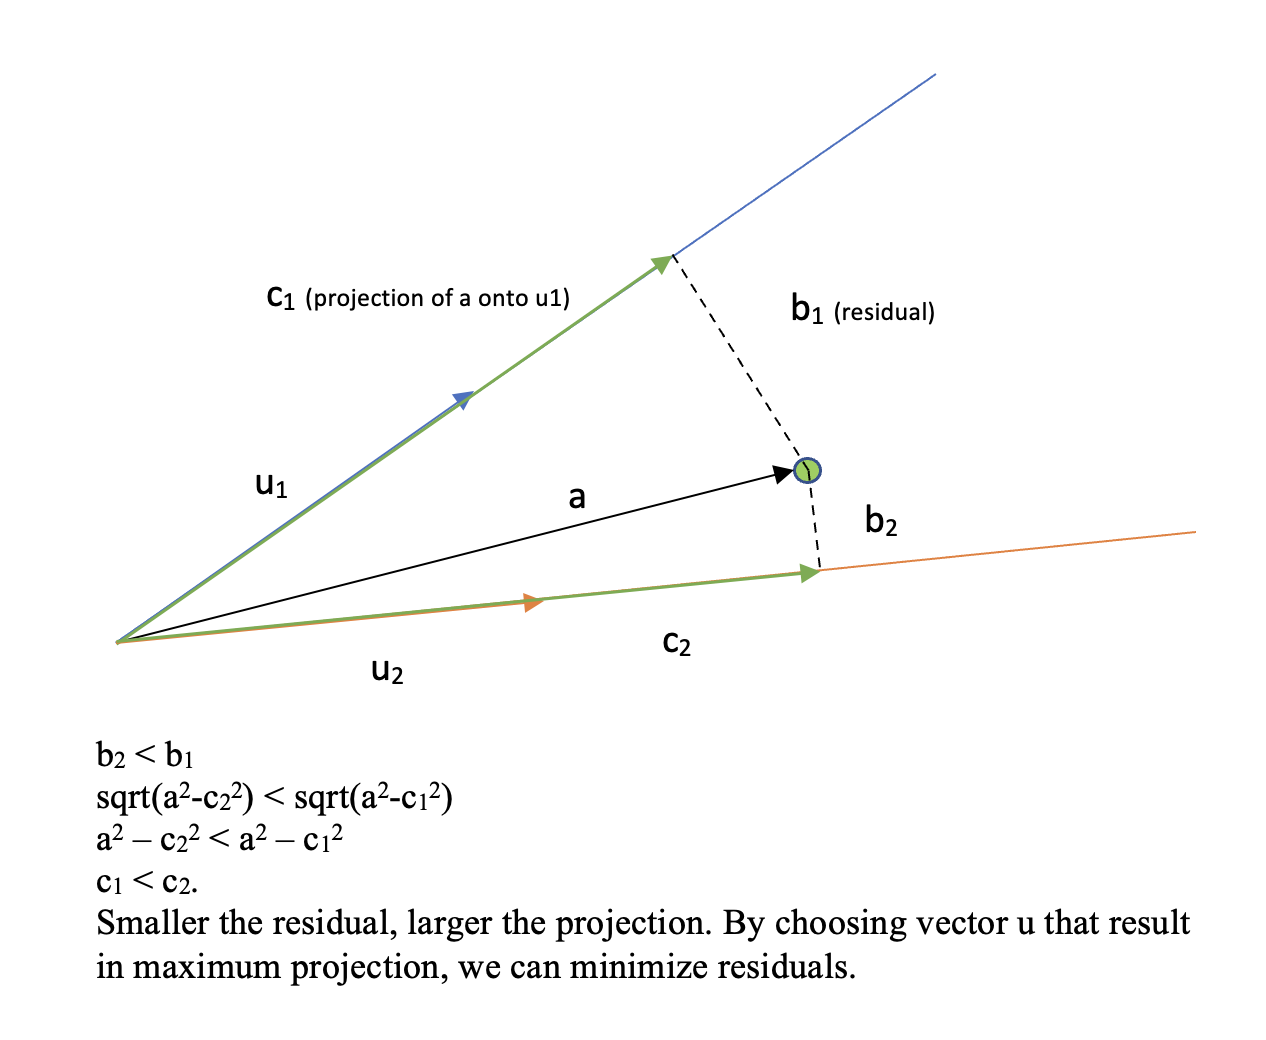
Thus, PCA takes the projections of all the data onto a unit vector, take the sums to find the line with minimum residuals that can explain the variation the most. The following shows the formula that PCA computes to find the best axis expressed using matrix form. The following equation needs to be maximized. 

$$
avg\,proj = \frac {1}{n}\sum (x_i^Tu)^2
$$
$$
= \frac {1}{n}\sum x_i^Tux_i^Tu 
$$
$$
= u^T \frac {1}{n}\sum x_ix_i^T u
$$

Also, using Lagrange mutltiplier to satsify the condition of the line being an unit vector, the following function is maximised.

$$
|u| = 1
$$
$$
u^Tu = 1
$$
$$
u^T \frac {1}{n}\sum x_ix_i^T u - \alpha (u^Tu -1)
$$



In order to maximize the above function, the function is set to be equal to zero. Rearranging the equation, it can be noticed that the lines that satisfy this corresponds to the eigenvectors of the covariance matrix.

$$
u^T  C u - \alpha (u^Tu -1)
$$
$$
\frac {d}{du}u^T  C u - \alpha (u^Tu -1) = 0
$$
$$
C u - \alpha u = 0
$$
$$
 C u = \alpha u 
$$
$$
C u = \lambda u 
$$

Thus, eigenvalues for the eigenvectors can be computed as follows:

Solve for
$$
|C-\lambda I| = 0
$$

Then, corresponding eigenvectors can be found by

and substitute lambda to 
$$
(C-\lambda I)v = 0
$$

Higher the eigenvalue, greater variability the eigenvector can represent. By dividing each eigenvalue by the total eigenvalues, the importance of a component can be expressed as fractions. Hence, PCA starts by accumulating the eigenvectors with highest eigenvalues until it reaches the threshold value usually set around 0.95.

After the set of eigenvectors are identified, the transformation matrix can be constructed by making eigenvectoes be the columns of the matrix, and perform matrix multiplication on data. It transforms the data into eigenspace with lower dimensions while retaining around 95% of the original variability. 

PCA described above is performed using scikit learn library. The standardization is performed before passing the data on PCA, as eigenvalue can be impacted by the values in an array (though the pixel values are all in the same scale and does not imapct relative eigenvalues).

In [ ]:
def standardize_PCA(X_train, X_test, n_components=0.95):
  """
  standaridize and perform PCA

  Parameters
  -----------------
  X (np array): array containing images
  n_components (float): percentage of variation retained

  Returns
  -----------------
  X (np array): dimantionally reduced X
  """
  # standardization
  X_train = StandardScaler().fit_transform(X_train)
  X_test = StandardScaler().fit_transform(X_test)

  # find pca
  pca = PCA(n_components=n_components)
  pca.fit(X_train)

  # transform data into pca
  X_train = pca.transform(X_train)
  X_test = pca.transform(X_test)
  return X_train, X_test

In [ ]:
X_ex_train_pca, X_ex_test_pca = standardize_PCA(X_ex_train, X_test)
X_in_train_pca, X_in_test_pca = standardize_PCA(X_in_train, X_test)
X_mix_train_pca, X_mix_test_pca = standardize_PCA(X_mix_train, X_test)

In [ ]:
print("dimensions of data after dimensionality reductions")
print("trining dataset for case 1: ", X_ex_train_pca.shape, y_ex_train.shape)
print("training dataset for case 2: ", X_in_train_pca.shape, y_in_train.shape)
print("training dataset for case 3: ", X_mix_train_pca.shape, y_mix_train.shape)

print("test dataset for case 1: ", X_ex_test_pca.shape, y_test.shape)
print("test dataset for case 2: ", X_in_test_pca.shape, y_test.shape)
print("test dataset for case 3: ", X_mix_test_pca.shape, y_test.shape)

dimensions of data after dimensionality reductions
trining dataset for case 1:  (4541, 155) (4541,)
training dataset for case 2:  (4509, 74) (4509,)
training dataset for case 3:  (4525, 155) (4525,)
test dataset for case 1:  (1006, 155) (1006,)
test dataset for case 2:  (1006, 74) (1006,)
test dataset for case 3:  (1006, 155) (1006,)


From the above, we can see that the data's demension is reduced. 

###**5. XGBoost**

**What is XGBoost?**

As it has been discussed, one of the difficulties in using decision trees is its sensitivity to data. When one data point is added, it can change the whole structure of the tree. This means decision trees can easily overfit to the data. There are three main techniques to solve this problem: reguralization, boosting, and bagging, and XGBoost is a gradient boosting technique optimized for reducing runtime while maintain its classification ability by using regularization and boosting. XGBoost is regarded as one of the optimal classification technique available. (NDIVIA, n.d.)

**How XGBoost works in binary classification?** (content here is greatly inspired by StatQuest (2020))

Just like gradient boosting, XGBoost starts by making initial prediction. The initial prediction of probability can be 0.5 where 0 and 1 are classes to be classified. Then, trees can be constructed so that the residuals from the initial prediction can be determined. While building the tree for predicting residuals, it makes use of similarity scores so that the leaves can have points with similar value of residuals. The equation of similarity score is given by

$$
Similarity\,Score = \frac {(\sum residual_i)^2} {\sum [previous\,probability_i \times (1-previous\,
probability_i)]+\lambda }$$

In initial tree, previous probability is 0.5 for all of the datapoint. Then, the decision boundary with largest similarity score difference from the root node, or largest gain, is chosen. The gain is calculated by

$$
Gain = left_{similarity} + right_{similarity} - root_{similarity}
$$

The process continues until the cover of the leaves, which is the denominator of similarity score calculation except for the regularization parameter lamda, is smaller than a threshold value usually default to 1 and a branch with cover less than 1 is pruned. The min_child_weight corresponds with this threshold value, and higher it is, more pruning happens. 

After the tree is constructed, the further pruning process begins. The gamma, parameter, is compared with gain of the split, and if the gain is smaller than gamma, that branch is pruned. This means that having higher number for gamma can prune the tree more to avoid overfitting. Also, the regularization parameter is in the denominator. Hence, higher regualrization parameter reduces the gain of a branch and encourages more pruning.

After the pruning, the output values, singifying how initial prediction should be adjusted for each leave, is computed by using the follwowing equation,

$$
O_{value}= \frac {(\sum residual_i)} {\sum [previous\,probability_i \times (1-previous\,
probability_i)]+\lambda }
$$

As the regualrization parameter is in the denominator here as well, it encourage less learning from the tree. Then, the log(odds) of initial predictions for all datapoints are updated by

$$
log(odds) = log(\frac {p}{1-p})
$$
$$
updated\,log(odds) = log(odds) + O_{value}
$$

, and the new predictions for the data are generated by passing the outputs to logit function for converting the log(odds) back to probability. 

$$
updated\,probability = \frac {e^{updated\,log(odds)}}{1+e^{updated\,log(odds)}}
$$

Based on the new predictions, new trees can be constructed using the same technique, until it reaches small residuals or maximum number of trees or estimators. This way, the trees can be constructed to cluster together the similar datapoints and gradually reduce residuals while avoiding under or overfitting. 

In summary, the basic parameters in XGBoost are regularization parameter (lamda), gamma, learning rate (eta), min_child_weight, and number of estimator. 

**Why those equations?** (content here is greatly inspired by StatQuest (2020))

The primary job for the tree is to come up with appropriate output values for each of the data that minimize the loss function. As we have covered in class, the loss function for classifcation is

$$
L(yi, pi) = -[y_ilog(p_i)+(1-y_i)log(p_i)]
$$

, where y refers to actual observation and p is prediction. Since pi in this case is the sum of initial prediction and output value, and due to regularization, the loss function for the XGBoost is

$$
Loss = [\sum_{i=1}^n L(y_i, p_i^0 + O_{value})] + \frac{1}{2}λO^2_{value}
$$

Also, XGBoost reduce the number of calcualtions by using Second Order Tayler approximation, 

$$
L(y, p_i + O_{value}) \approx L(y, pi) + [\frac {d}{dp_i} L(y, pi)]O_{value} + \frac{1}{2}[\frac {d^2}{dp_i^2} L(y, pi)]O^2_{value}
$$

This result in the following loss function,

$$
Loss \approx [\sum_{i=1}^n L(y, pi) + [\frac {d}{dp_i} L(y, pi)]O_{value} + \frac{1}{2}[\frac {d^2}{dp_i^2} L(y, pi)]O^2_{value}] + \frac{1}{2}λO^2_{value}
$$

Expressing gradient and hessian in terms as g and h, and omitting constant that becomes zero when differntiating (we can do this as we are interested in relative losses), the loss function is approximated as 

$$
Loss \approx [\sum_{i=1}^n g_iO_{value} + \frac{1}{2}h_iO^2_{value}] + \frac{1}{2}λO^2_{value}
$$
$$
Loss \approx (g_1+g_2+...+g_n)O_{value} + \frac{1}{2}(h_1+h_2+...+h_n+\lambda)O^2_{value}
$$

Then, when we aim for the output value that minimize the loss, we take partial derivative of the loss function with respect to output value and set it to zero. This will give

$$
\frac{d}{dO_{value}} Loss \approx (g_1+g_2+...+g_n) + (h_1+h_2+...+h_n+\lambda)O_{value}
$$
$$
(g_1+g_2+...+g_n) + (h_1+h_2+...+h_n+\lambda)O_{value} = 0
$$
$$
O_{value} = \frac{-(g_1+g_2+...+g_n)}{(h_1+h_2+...+h_n+\lambda)}
$$

The first and scond derivative of L(yi,log(odds)) are determined as follows

$$
\frac{d}{dlog(odds)}L(y_i, log(odds)_i) =g_i= -y_i + \frac {e^{log(odds)_i}}{1+e^{log(odds)_i}} = -(y_i-p_i)
$$
$$
\frac{d^2}{dlog(odds)^2}L(y_i, log(odds)_i) =h_i = \frac {e^{log(odds)_i}}{1+e^{log(odds)_i}} \times \frac {1}{1+e^{log(odds)_i}} = p_i \times (1-p_i)
$$

Substituting them in, the output value that minimizes the loss is computed by

$$
O_{value} = \frac{\sum (y_i-p_i)}{(\sum pi\times(1-p_i))+\lambda}
$$
$$
O_{value}= \frac {(\sum residual_i)} {\sum [previous\,probability_i \times (1-previous\,
probability_i)]+\lambda }
$$

, which is the same equation used above. However, before computing the output value, we need to structure the tree in a way that minimize loss. Given the above equation for the output value that minimizes the loss, we can compute the approximated loss for a tree by substituting in the output value in the approximate loss function.

$$
Loss \approx (g_1+g_2+...+g_n)O_{value} + \frac{1}{2}(h_1+h_2+...+h_n+\lambda)O^2_{value}
$$

$$
Loss \approx (g_1+g_2+...+g_n)\frac{-(g_1+g_2+...+g_n)}{(h_1+h_2+...+h_n+\lambda)} + \frac{1}{2}(h_1+h_2+...+h_n+\lambda)\frac{-(g_1+g_2+...+g_n)^2}{(h_1+h_2+...+h_n+\lambda)^2}
$$
$$
Loss \approx \frac{-(g_1+g_2+...+g_n)^2}{(h_1+h_2+...+h_n+\lambda)} + \frac{1}{2}\frac{-(g_1+g_2+...+g_n)^2}{(h_1+h_2+...+h_n+\lambda)}
$$
$$
Loss \approx -\frac{1}{2}\frac{-(g_1+g_2+...+g_n)^2}{(h_1+h_2+...+h_n+\lambda)}
$$

As we are only interested in relative values from loss function, 

$$
Loss \approx -\frac{-(g_1+g_2+...+g_n)^2}{(h_1+h_2+...+h_n+\lambda)}
$$

$$
Loss \approx -\frac {(\sum residual_i)^2} {\sum [previous\,probability_i \times (1-previous\,
probability_i)]+\lambda }
$$

, which corresponds to the similarity score. As similarity score = -loss, by choosing the boundary with largest similarity score, it is effectively choosing split that leads to smallest possible approximated loss when best output value is chosen. However, not all of the patterns of tree is examined as the algorithm splits the data by only observing the gain just after the split. Thus, the algorithm is greedy algorithm, which can acheive faster runtime. 

###**6. Model training**

####**Model selection**



The function below performs random search cross validation for finding set of parameters that result in better validation score specified. In this scenario, n_estimator is set to be 100, the default value for XGBoostClassifer, to avoid using up too much memory. The grid search cross validation can examine all combinations of parameters inputted, but it took significant amount of time. Hence, random search cross validation is chosen. With enough computational power, grid search cross validation should be performed including n_estimators.

**Metrics to be used, Recall**

In evaluating the performance of classification, it is important to use appropriate metrics depending on the problem. In the case of sobriety classification, the false negative, drunk person being incorrectly classified as sober, has the largest consequence to be avoided. False positive, sober person being incorrectly classified as drunk, is just fun, but the false negative can cause drunk driving, which can lead to devastating consequences. 

Hence, recall is appropriate metrics to be used in this case. Recall is the ratio of correctly predicted positive classes to all items that are actually positive. Smaller the recall value, less false negative there is. 

In [ ]:
def randomsearchCV_XGB_binary(X_train, y_train, parameters, scoring_type='f1_weighted'):
  """
  Perform random search cross validation for XGBoost binary classier

  Parameters
  -----------------
  X_train (np array): the features used in predicting y in training data
  y_train (np array): the labels to be classifed in the training data
  parameters (dict): parameters and distributions to take parameters from
  scoring_type (str, default=f_1weighted): score to be looked at when choosing the best parameters

  Returns
  -----------------
  best params (dict): best parameters identified stored in a dict
  best score (float): best score from the model with the best parameters
  """
  estimator= XGBClassifier(objective= 'binary:logistic',
                          n_estimators=100,
                          tree_method='hist',
                          verbose=True,
                          seed=42)

  cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)

  scoring= {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
           'f1_macro': make_scorer(f1_score, average = 'macro'),
           'f1_weighted': make_scorer(f1_score, average = 'weighted')}
  
  rand_search = RandomizedSearchCV(
      estimator=estimator,
      param_distributions=parameters,
      scoring = scoring[scoring_type],
      n_iter=20,
      n_jobs=10,
      cv = cv,
      verbose=True
  )

  rand_search.fit(X_train, y_train)

  return rand_search.best_params_, rand_search.best_score_

####**Training model on dataset**

**Case 1: Training on external dataset**

In [ ]:
parameters = {
      'learning_rate': uniform(loc=0.001, scale=1),
      'gamma': uniform(loc=0, scale=2),
      'lamda': uniform(loc=0, scale=2),
      'min_child_weight': uniform(loc=0, scale=2)
  }

params, score = randomsearchCV_XGB_binary(X_ex_train_pca, y_ex_train, parameters, scoring_type='recall')

print("best parameters: ", params)
print("best score: ", score)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
best parameters:  {'gamma': 0.14931141484673538, 'lamda': 1.2587893779073591, 'learning_rate': 0.43906818804892767, 'min_child_weight': 0.6041280605383466}
best score:  0.9522269248670359


In [ ]:
xgb_clf_ex = XGBClassifier(objective='binary:logistic', 
                          n_estimators=100,
                          gamma=params['gamma'],
                          lamda=params['lamda'],
                          learning_rate=params['learning_rate'],
                          min_child_weight=params['min_child_weight'],
                          tree_method='hist',
                          seed=42)
xgb_clf_ex.fit(X_ex_train_pca, y_ex_train)

XGBClassifier(gamma=0.14931141484673538, lamda=1.2587893779073591,
              learning_rate=0.43906818804892767,
              min_child_weight=0.6041280605383466, seed=42, tree_method='hist')

**Case 2: Training on personal dataset**

In [ ]:
params, score = randomsearchCV_XGB_binary(X_in_train_pca, y_in_train, parameters, scoring_type='recall')

print("best parameters: ", params)
print("best score: ", score)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
best parameters:  {'gamma': 0.48471603655509643, 'lamda': 1.5117608385653838, 'learning_rate': 0.16190370332026782, 'min_child_weight': 1.375804655432541}
best score:  0.9844786142878789


In [ ]:
xgb_clf_in = XGBClassifier(objective='binary:logistic', 
                          n_estimators=100,
                          gamma=params['gamma'],
                          lamda=params['lamda'],
                          learning_rate=params['learning_rate'],
                          min_child_weight=params['min_child_weight'],
                          tree_method='hist',
                          seed=42)
xgb_clf_in.fit(X_in_train_pca, y_in_train)

XGBClassifier(gamma=0.48471603655509643, lamda=1.5117608385653838,
              learning_rate=0.16190370332026782,
              min_child_weight=1.375804655432541, seed=42, tree_method='hist')

**Case 3: Training on mixed dataset**

In [ ]:
params, score = randomsearchCV_XGB_binary(X_mix_train_pca, y_mix_train, parameters, scoring_type='recall')

print("best parameters: ", params)
print("best score: ", score)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
best parameters:  {'gamma': 0.04826716626982286, 'lamda': 0.9295132111180016, 'learning_rate': 0.4254722439429356, 'min_child_weight': 1.846612800783459}
best score:  0.9561105357310987


In [ ]:
xgb_clf_mix = XGBClassifier(objective='binary:logistic', 
                          n_estimators=100,
                          gamma=params['gamma'],
                          lamda=params['lamda'],
                          learning_rate=params['learning_rate'],
                          min_child_weight=params['min_child_weight'],
                          tree_method='hist',
                          seed=42)
xgb_clf_mix.fit(X_mix_train_pca, y_mix_train)

XGBClassifier(gamma=0.04826716626982286, lamda=0.9295132111180016,
              learning_rate=0.4254722439429356,
              min_child_weight=1.846612800783459, seed=42, tree_method='hist')

In all of the training datasets, cross validation recall score is above 0.95, which is extremely high. The result from cross validation can be compared with the test set. 

###**7. Predictions**

This section performs predictions to visualize result in the next section. It is important to keep in mind that the principle components are different between datasets, and corresponding trasnformed test datasets need to be used for performing predictions.

In [ ]:
# case 1
pred_ex = xgb_clf_ex.predict(X_ex_test_pca)
# case 2
pred_in = xgb_clf_in.predict(X_in_test_pca)
# case 3
pred_mix = xgb_clf_mix.predict(X_mix_test_pca)

###**8. Visualization and Conclusion**

For the visualizations, classifcation report and confusion matrix are made for each case. The macro recall is compared with the cross validation result. Also, the plot function is utilized to see what kind of predictions are made to the test images. 

**Case 1: External Dataset**

In [ ]:
print(classification_report(y_test, pred_ex))

              precision    recall  f1-score   support

           0       0.70      0.49      0.58       316
           1       0.79      0.91      0.85       690

    accuracy                           0.77      1006
   macro avg       0.75      0.70      0.71      1006
weighted avg       0.77      0.77      0.76      1006



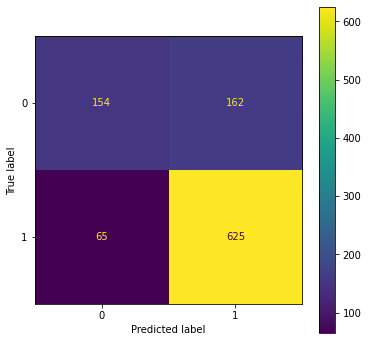

In [ ]:
cm = confusion_matrix(y_test, pred_ex)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

rcParams['figure.figsize'] = 6,6
disp.plot()
plt.show()

**Case 2: Personal Dataset**

In [ ]:
print(classification_report(y_test, pred_in))

              precision    recall  f1-score   support

           0       0.66      0.77      0.71       316
           1       0.88      0.82      0.85       690

    accuracy                           0.80      1006
   macro avg       0.77      0.79      0.78      1006
weighted avg       0.81      0.80      0.80      1006



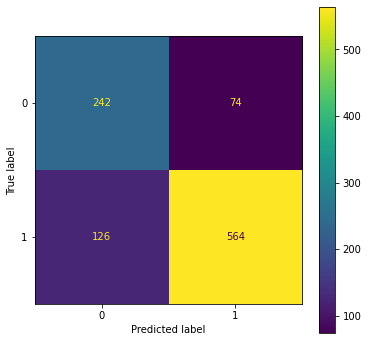

In [ ]:
cm = confusion_matrix(y_test, pred_in)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

rcParams['figure.figsize'] = 6,6
disp.plot()
plt.show()

**Case 3: Mixed Dataset**

In [ ]:
print(classification_report(y_test, pred_mix))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       316
           1       0.98      0.97      0.97       690

    accuracy                           0.96      1006
   macro avg       0.96      0.96      0.96      1006
weighted avg       0.96      0.96      0.96      1006



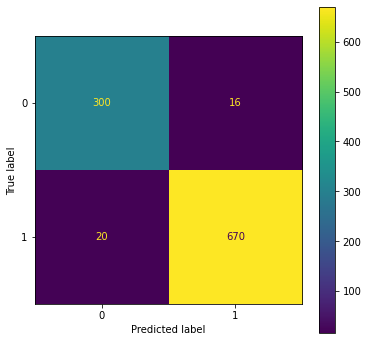

In [ ]:
cm = confusion_matrix(y_test, pred_mix)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

rcParams['figure.figsize'] = 6,6
disp.plot()
plt.show()

In [ ]:
# change pred to see the predictions from different models
plot_rand_imgs(X_test, img_size, pred=pred_mix, actual=y_test)

####**Conclusion**

In case 1 and 2, the recall is around 0.75, while the cross validation scores were around 0.95. This signifies the possibility of overfitting. It was expected as data was skewed from the start. Furthermore, the model has technically seen half of the faces in test dataset. If the model learns to classify the faces in training dataset, they can guess randomely for the unseen faces to achieve recall around 0.75. Thus, it is likely that the model has learned to classify images themselves in the training dataset, rather than sobriety.

The performance of the classification is exceptionally high for the mixed dataset, case 3, for both cross validation and test dataset. However, it is important to be skeptical for this extremely good result. The outcome is likely from the small number of face used to train the model that made the model learn really well to classify individual faces rather than classifying sobriety level. The data augumentation is performed, but the model has technically seen all of the faces present in the dataset.

However, the experiment could find XGBoost's classification capability and speed to fit the data after dimensionality reduction, which becomes useful in future work. 

**Future Implication**

The project confirmed the limitation of data augumentation as a way to solve the problem of having small dataset. In the future, it is necessary to collect more data to train the model to focus on classifying sober and drunk individuals. Ideally, the dataset should contain the data of same individuals with differing sobriety level like external dataset to make the model not to learn to perform facial recognition.  

Another potential problem can be the information lost during resizing of the image. For fast and less momory intensive training, the image size is set to be 32 by 32 pixels, which is small. Also, PCA only extract covariance of the data meaning they only retain the linear correlation of the data. Hence, when the data is complex and non-linearly correlated, PCA can greatly reduce the information of the data. Autoencoder can retain non-linear relationships between features while reducing the dimensions by using deep learning. Thus, pretrained autoencoders can be tested to see if they can increase the performance. (Muaz, U, 2019)

Furthermore, behavioral based intoxication recognition is traditionally conducted on videos and audio. In the future, CNN-RNN based machine learning model can be trained to classify the sober from drunk people to see if having more features and datapoints can help increase the classification performance. 

###**9. Executive Summary**

The PCA and XGBoost technique is trained on external datasets and personal datasets to classify sober and drunk faces. The faces are extracted from the images using OpenCV haarcascade model, and all of the facial images were augumented to amplify the size of the dataset to cope with the small size of initial dataset. 

Then, the results from training the model only on external and personal datasets, and on mixture of both datasets of same size are compared. The comparison revealed the possibility that the model has learned to classify faces themselves rather than learning to classify sober from drunk. This revelas the limitation of data augumentation and importance of data used.

Finally, the paper has drawn futher implications of the work as the collection of better quality and larger data, the use of pretrained autoencoders for better dimensionality reduction, and the use of different datatypes such as video and audio that captures behavioral changes better and corresponding machine learning models. 

###**10. References**

Chang, J., Hoke, T., Dastjerdi, P. & Kumar, H. 2019. Sobr. https://github.com/hoke-t/Sobr

Jaadi, Z. 2022. A Step-by-Step Explanation of Principal Component Analysis (PCA). https://builtin.com/data-science/step-step-explanation-principal-component-analysis

Muaz, U. 2019. Autoencoders vs PCA: when to use ?. https://towardsdatascience.com/autoencoders-vs-pca-when-to-use-which-73de063f5d7

n.d. 2014. OpenCV. https://github.com/kipr/opencv

NDIVIA.n.d. XGBoost. https://www.nvidia.com/en-us/glossary/data-science/xgboost/

StatQuest. 2020. XGBoost Part 2 (of 4): Classification. https://www.youtube.com/watch?v=8b1JEDvenQU&t=2s

StatQuest. 2020. XGBoost Part 3 (of 4): Mathematical Details. https://www.youtube.com/watch?v=ZVFeW798-2I



LINK for the Google Colab: https://colab.research.google.com/drive/1JZAiS3sdIEixb-XdTQkJ5KqtFryppggo?usp=sharing